# Notebook avec premières analyses sur les haïkus

## Statistiques descriptives - Wordclouds

In [3]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
os.chdir("C:/Users/maxim/Documents/ensae-python-2018/Data/")

In [9]:
base_haikus = pd.read_csv("haikus_scraping_v3_20181210.csv",",")

In [10]:
base_haikus.head()

,Unnamed: 0,url,id_auteur,auteur,sexe,pays,haiku
0,0,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,quin-p,Philippe Quinta,H,France,"Fut-elle pleine\\déjà, elle décroit\\la lune"
1,1,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,py-d,Daniel Py,H,France,Lune parfaitement ronde\\Buée sur la vitre
2,2,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,alex-m,Marlène Alexa,F,Egypte,hiver\\dans les yeux de grand-mère\\une ombre ...
3,3,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,sang-r,Rahmatou Sangotte,F,France,ciel gris -\\une odeur d'oignons\\caramélisés
4,4,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,rais-c,Carol Raisfeld,F,USA,la fille du pasteur\\sa robe du dimanche\\de l...


In [11]:
# Création d'un balanced dataset 
base_haikus = base_haikus.sort_values(by=["sexe"], ascending=True)
base_haikus = base_haikus

In [12]:
len(base_haikus)

3285

In [13]:
base_haikus['haiku']

2024    festival\\les insectes cabriolent\\sur la Gran...
1092    Mistral\\elle traverse hors des clous\\la poub...
697     vieille rue\\des pétales d'amandier\\sur la bé...
1274    Chatte en chaleur\\Sur ses côtes apparentes\\L...
3233    Il a oublié\\d'effacer les nuages\\le laveur d...
222     (magnet sur le frigo --\\snack après snack \\d...
493     Saint Valentin\\nos baisers ont un parfum\\de ...
860     Naissance du jour\\un avion silencieux\\traver...
858     vente de l'Aïd\\l'épicier Sikh\\ouvert plus ta...
914     Le premier orage\\Un lac piqueté de gouttes\\P...
2548               couché\\sur le chemin le ciel\\de boue
2332    à chaque voiture\\une aile de la pie\\battant ...
1572    nécropole antique\\les tombes exhumées fleurie...
3169    vent violent\\le pissenlit essaime\\au creux d...
288     faim de vie\\les petits de Gaza\\n'oublieront pas
569     étang boueux\\sur leurs bateaux en papier\\les...
366     sérieusement\\sur la fin du monde\\ces trois v...
571     Après 

In [14]:
sum(base_haikus['sexe']=="H")

2211

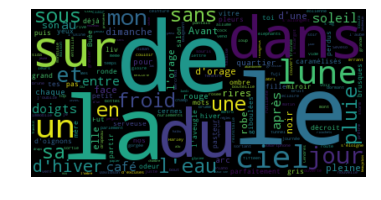

In [120]:
# Start with one review:
haikus = str(base_haikus["haiku"])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(haikus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [121]:
### Remove stopwords
import nltk

from nltk.corpus import stopwords
mots_vides = stopwords.words('french')
mots_vides.append("les")
stopwords=set(mots_vides)

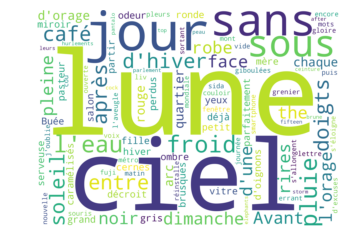

In [122]:
wordcloud2 = WordCloud(   stopwords=stopwords,
                          background_color='white',
                          width=2500,
                          height=1800, 
                        max_words=100, 
                         ).generate(haikus)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.show()

In [123]:
haikus_F = str(base_haikus[base_haikus['sexe'] == "F"]["haiku"])
haikus_H = str(base_haikus[base_haikus['sexe'] == "H"]["haiku"])

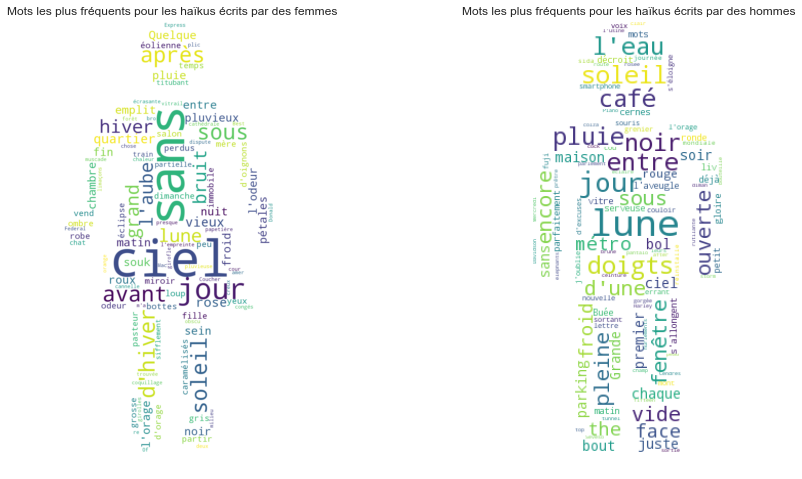

In [124]:
# Wordcloud pour les haikus écrits par des hommes et des femmes

# Pour les femmes
masqueF = np.array(Image.open("images/symbole-femme.png"))
wordcloud_femmes = WordCloud(stopwords=stopwords, 
                             background_color="white", 
                             #mode="RGBA", 
                             max_words=100, 
                             mask=masqueF).generate(haikus_F)

# Pour les hommes
masqueH = np.array(Image.open("images/symbole-man2.png"))
wordcloud_hommes = WordCloud(stopwords=stopwords, 
                             background_color="white", 
                             mode="RGBA", 
                             max_words=100, 
                             mask=masqueH).generate(haikus_H)
# Plot
# plt.figure(figsize=[7,7])
# Plot des graphes
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(1,2,1)
plt.imshow(wordcloud_femmes, interpolation="bilinear")
plt.axis("off")
plt.title("Mots les plus fréquents pour les haïkus écrits par des femmes")
ax2 = fig.add_subplot(1,2,2)
plt.imshow(wordcloud_hommes, interpolation="bilinear")
plt.axis("off")
plt.title("Mots les plus fréquents pour les haïkus écrits par des hommes")

# store to file
plt.savefig("images/wordcloud_v2_20181110.png", format="png")

## Modélisations 

Ici, on considère l'ensemble des mots comme régresseurs, et on teste différents modèles pour prédire le sexe (régression logistique, réseau de neurones, forêts aléatoires notamment).

### Création des jeux de données pour l'entraînement et la validation des modèles 

In [125]:
#### Calage d'un premier modèle en ne conservant que les homes et les femmes (certains haïkus n'ont pas d'auteur
# avec un sexe déterminé car utilisation d'un pseudo)
base_haikus_model = base_haikus[base_haikus.sexe != "?"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
               base_haikus_model['haiku'], base_haikus_model["sexe"])
len(base_haikus_model)

3404

In [127]:
## Création de la matrice document-terme avec le score tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
## Voir si on peut gérer les n-grammes ici pour voir si ça améliore le pouvoir prédictif.
# Approches Word2Vec librairies spacy et gensim...
# Voir avec modèles pré-entraînés. 

pipe = make_pipeline(CountVectorizer(ngram_range=(1,3)), TfidfTransformer())

pipe.fit(X_train)
feat_train = pipe.transform(X_train)
feat_train.shape

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(2553, 39638)

In [128]:
feat_test = pipe.transform(X_test)
feat_test.shape
## NB : moyen propre, on perd les mots qui sont dans X_test et pas dans X_train vu qu'on applique pipe (pas très grave).
# Le dictionnaire est constitué à partir du vocabulaire de X_train.

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(851, 39638)

### Forêts aléatoires

In [129]:
## Prédiction du sentiment avec une random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(feat_train, y_train)
# Voir dans xgboost ou lightgbm si on peut mieux paramétrer pour un gd nombre de régresseurs. 
# catboost aussi.
# fasttext deeplearning - librairie pour données textuelles, FB

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [130]:
clf.score(feat_test, y_test)

0.6721504112808461

In [131]:
y_pred = clf.predict(feat_test)

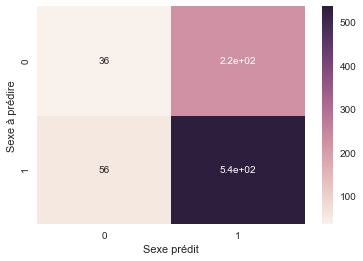

In [132]:
## Visualisation avec package sns
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Régression logistique 

In [133]:
from sklearn.linear_model import LogisticRegression

# Pénalité L1 standard pour des modèles de régression logistique quand données textuelles
lreg = LogisticRegression(penalty= "l2") ## Voir quelle pénalité est meilleure en moyenne

# Entraînement modèle 
lreg.fit(X= feat_train, y=y_train)

# Prédiction globale
lreg.score(X=feat_test, y=y_test)


0.7015276145710928

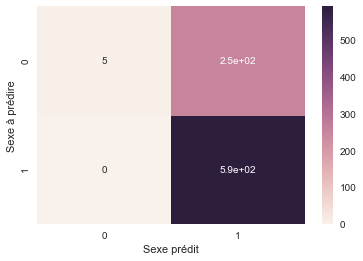

In [134]:
y_pred = lreg.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Réseau de neurones

In [135]:
## Réseau de neurones
from sklearn.neural_network import MLPClassifier

reseau_neur = MLPClassifier(hidden_layer_sizes=(1000,))

# Entraînement modèle
reseau_neur.fit(X=feat_train, y= y_train)

# Prédiction globale
reseau_neur.score(X=feat_test, y= y_test)

0.6462984723854289

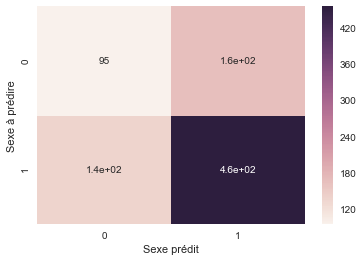

In [136]:
y_pred = reseau_neur.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Modèle idiot pour benchmark

In [137]:
## Dummy
from sklearn.dummy import DummyClassifier

idiot = DummyClassifier(strategy="stratified")

# Entraînement modèle
idiot.fit(X=feat_train, y= y_train)

# Prédiction globale
idiot.score(X=feat_test, y= y_test)

0.5663924794359577

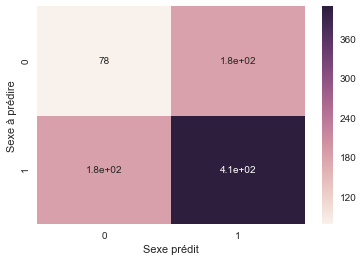

In [138]:
y_pred = idiot.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Comparaison des modèles précédents avec courbes Roc

In [139]:
### Courbes ROC pour comparer les différentes approches
import numpy
np_train = numpy.hstack([feat_train.todense()])
np_test = numpy.hstack([feat_test.todense()])
pmodelreg = lreg.predict_proba(np_test)[:, 1]
pmodelFor = clf.predict_proba(np_test)[:, 1]
pmodelResNeur = reseau_neur.predict_proba(np_test)[:, 1]
pmodelIdiot = idiot.predict_proba(np_test)[:, 1]
#lreg.predict_proba(y_test)


In [140]:
# Conversion de l'objet y en numérique (0/1 plutôt que homme femme pour pouvoir tracer la courbe)
y_test_num= (y_test == "H")
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test_num, pmodelreg)
fpr2, tpr2, th2 = roc_curve(y_test_num, pmodelFor)
fpr3, tpr3, th3 = roc_curve(y_test_num, pmodelResNeur)
fpr4, tpr4, th4 = roc_curve(y_test_num, pmodelIdiot)

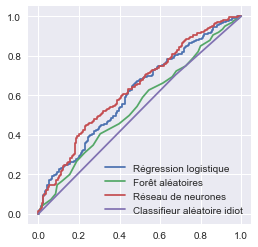

In [141]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='Régression logistique')
ax.plot(fpr2, tpr2, label='Forêt aléatoires')
ax.plot(fpr3, tpr3, label='Réseau de neurones')
ax.plot(fpr4, tpr4, label='Classifieur aléatoire idiot')
ax.legend();


## Tuning des hyperparamètres

Ici, on teste différents hyperparamètres pour les modèles de régression, afin d'améliorer la précision des résultats. On utilise la validation croisée pour construire le modèle.

### Forêts aléatoires

In [101]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#'criterion':('gini', 'entropy'), 
              #'n_estimators':[10,20,50],
parameters = {'max_features':("auto", "log2", 500, 1000, None),
             'max_depth':[None, 100, 50, 30, 20, 10],
              'min_samples_leaf':[1,2,5,10,20]}

# On utilise comme score le score F1 pour une moyenne du rappel et de la précision (objectif sous-jacent) :
# ne pas coder trop souvnet en homme.
svc = RandomForestClassifier()
clf = GridSearchCV(svc, parameters, cv=5, scoring = "f1_weighted", verbose=5000)
clf.fit(feat_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] max_depth=None, max_features=auto, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, score=0.614318, total=   0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, score=0.593679, total=   0.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, score=0.610947, total=   0.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, score=0.642987, total=   0.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elaps

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=auto, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.7s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=5 ...........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.8s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=10 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.9s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    5.0s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.1s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=10 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.1s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.2s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    5.3s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=20 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    5.4s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    5.4s remaining:    0.0s
[CV] max_depth=None, max_features=auto, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    5.5s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, score=0.620355, total=   0.3s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    5.9s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_fea

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=None, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    8.0s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=2 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    8.1s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    8.2s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5 ...........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    8.3s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    8.3s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    8.4s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=5 ...........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.4s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=10 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    8.5s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    8.5s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    8.6s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=10 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    8.6s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=10 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.7s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    8.8s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    8.8s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    8.9s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=20 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    8.9s remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.0s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=1 ............
[CV]  max_depth=None, max_features=500, min_samples_leaf=1, score=0.607831, total=   0.8s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    9.9s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=1 ............
[CV]  max_depth=None, max_features=500, min_samples_leaf=1, score=0.579322, total=   0.8s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   10.8s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=1 ............
[CV]  max_depth=None, max_featur

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   19.3s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=20 ...........
[CV]  max_depth=None, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   19.4s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=20 ...........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   19.6s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=20 ...........
[CV]  max_depth=None, max_features=500, min_samples_leaf=20, score=0.575925, total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   19.7s remaining:    0.0s
[CV] max_depth=None, max_features=500, min_samples_leaf=20 ...........
[CV]  max_depth=None, max_features=500, min_samples_leaf=20, score=0.570012, total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   19.9s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_features=1000, min_samples_leaf=1, score=0.597049, total=   0.9s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   21.0s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_featur

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=1000, min_samples_leaf=20, score=0.564475, total=   0.2s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   35.6s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=20 ..........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=None, max_features=1000, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:   35.9s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=1000, min_samples_leaf=20, score=0.565121, total=   0.2s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:   36.2s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=1000, min_samples_leaf=20, score=0.561628, total=   0.2s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:   36.5s remaining:    0.0s
[CV] max_depth=None, max_features=1000, min_samples_leaf=20 ..........
[CV]  max_depth=None, max_features=1000, min_samples_leaf=20, score=0.572525, total=   0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.7s remaining:    0.0s
[CV] max_depth=None, max_features=None, min_samples_leaf=1 ...........
[CV]  max_depth=None, max_fe

[CV]  max_depth=100, max_features=auto, min_samples_leaf=2, score=0.572952, total=   0.2s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=2 ............
[CV]  max_depth=100, max_features=auto, min_samples_leaf=2, score=0.592078, total=   0.2s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=2 ............
[CV]  max_depth=100, max_features=auto, min_samples_leaf=2, score=0.606790, total=   0.2s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=2 ............
[CV]  max_depth=100, max_features=auto, min_samples_leaf=2, score=0.594433, total=   0.2s
[Parallel(n_jobs=1)]: Done 134 out of 134 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=2 ............
[CV]  max_depth=100, max_features=au

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=10 ...........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 146 out of 146 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=20 ...........


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=auto, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=log2, min_samples_leaf=1, score=0.579262, total=   0.1s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=1, score=0.579775, total=   0.2s
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=1, score=0.599723, total=   0.2s
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:  1.4min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=1, score=0.581249, total=   0.2s
[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=lo

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=2 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=2, score=0.569036, total=   0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=5 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=5 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=5 ............
[CV]  max_depth=100, max_features=lo

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=100, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=5 ............
[CV]  max_depth=100, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=100, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=10 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_feature

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c


[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=log2, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=1 .............
[CV]  max_depth=100, max_features=500, min_samples_leaf=1, score=0.579988, total=   0.5s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=1 .............
[CV]  max_depth=100, max_features=500, min_samples_leaf=1, score=0.614977, total=   0.5s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:  1.5min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=1 .............
[CV]  max_depth=100, max_features=500, min_samples_leaf=1, score=0.623656, total=   0.5s
[Parallel(n_jobs=1)]: Done 178 out of

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 196 out of 196 | elapsed:  1.6min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 197 out of 197 | elapsed:  1.6min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=20 ............
[CV]  max_depth=100, max_features=500, min_samples_leaf=20, score=0.563528, total=   0.2s
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:  1.6min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=20 ............
[CV]  max_depth=100, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 199 out of 199 | elapsed:  1.6min remaining:    0.0s
[CV] max_depth=100, max_features=500, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=500, min_samples_leaf=20, score=0.565450, total=   0.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.6min remaining:    0.0s
[CV] max_depth=100, max_features=1000, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=1000, min_samples_leaf=1, score=0.594952, total=   0.9s
[Parallel(n_jobs=1)]: Done 201 out of 201 | elapsed:  1.7min remaining:    0.0s
[CV] max_depth=100, max_features=1000, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=1000, min_samples_leaf=1, score=0.579654, total=   0.9s
[Parallel(n_jobs=1)]: Done 202 out of 202 | elapsed:  1.7min remaining:    0.0s
[CV] max_depth=100, max_features=1000, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=1000, min_samples_leaf=1, score=0.619700, total=   0.7s
[Parallel(n_jobs=1)]: Done 203 out of 203 | elapsed:  1.7min remaining:    0.0s
[CV] max_depth=100, max_features=1000, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=10

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=100, max_features=1000, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 224 out of 224 | elapsed:  1.9min remaining:    0.0s
[CV] max_depth=100, max_features=1000, min_samples_leaf=20 ...........
[CV]  max_depth=100, max_features=1000, min_samples_leaf=20, score=0.566098, total=   0.1s
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  1.9min remaining:    0.0s
[CV] max_depth=100, max_features=None, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=None, min_samples_leaf=1, score=0.612360, total=   2.4s
[Parallel(n_jobs=1)]: Done 226 out of 226 | elapsed:  1.9min remaining:    0.0s
[CV] max_depth=100, max_features=None, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=None, min_samples_leaf=1, score=0.592639, total=   3.5s
[Parallel(n_jobs=1)]: Done 227 out of 227 | elapsed:  2.0min remaining:    0.0s
[CV] max_depth=100, max_features=None, min_samples_leaf=1 ............
[CV]  max_depth=100, max_features=

[CV]  max_depth=50, max_features=auto, min_samples_leaf=2, score=0.587562, total=   0.1s
[Parallel(n_jobs=1)]: Done 259 out of 259 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=2, score=0.578171, total=   0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=5, score=0.562579, total=   0.0s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=5, score=0.566098, total=   0.0s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=auto, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 266 out of 266 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 269 out of 269 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 271 out of 271 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 272 out of 272 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=1, score=0.573515, total=   0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=50, max_features=log2

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 283 out of 283 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 284 out of 284 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 285 out of 285 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 286 out of 286 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 287 out of 287 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=50, max_features=log2

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=50, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 295 out of 295 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 296 out of 296 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=50, max_features=log

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=50, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=50, max_features=500, min_samples_leaf=1, score=0.595703, total=   0.3s
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=50, max_features=500, min_samples_leaf=1, score=0.612107, total=   0.3s
[Parallel(n_jobs=1)]: Done 302 out of 302 | elapsed:  2.6min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=50, max_features=500, min_samples_leaf=1, score=0.585711, total=   0.7s
[Parallel(n_jobs=1)]: Done 303 out of 303 | elapsed:  2.7min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=50, max_features=500, min_

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 322 out of 322 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=50, max_features=500, min_samples_leaf=20, score=0.564142, total=   0.0s
[Parallel(n_jobs=1)]: Done 323 out of 323 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=20 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=50, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=50, max_features=500, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=50, max_features=1000, min_samples_leaf=1, score=0.603037, total=   0.4s
[Parallel(n_jobs=1)]: Done 326 out of 326 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=50, max_features=1000, min_samples_leaf=1, score=0.582330, total=   0.5s
[Parallel(n_jobs=1)]: Done 327 out of 327 | elapsed:  2.8min remaining:    0.0s
[CV] max_depth=50, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=50, max_features=1000, m

[CV]  max_depth=50, max_features=None, min_samples_leaf=2, score=0.609169, total=   1.2s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=50, max_features=None, min_samples_leaf=2 .............
[CV]  max_depth=50, max_features=None, min_samples_leaf=2, score=0.604928, total=   1.2s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=50, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=None, min_samples_leaf=5, score=0.602453, total=   1.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=50, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=None, min_samples_leaf=5, score=0.605755, total=   1.0s
[Parallel(n_jobs=1)]: Done 362 out of 362 | elapsed:  3.2min remaining:    0.0s
[CV] max_depth=50, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=50, max_features=None, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 393 out of 393 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 394 out of 394 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 395 out of 395 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 397 out of 397 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 398 out of 398 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 399 out of 399 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=1, score=0.568047, total=   0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=1 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=log2, min_samples_leaf=1, score=0.568047, total=   0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=1, score=0.569018, total=   0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=1, score=0.562579, total=   0.0s
[Parallel(n_jobs=1)]: Done 404 out of 404 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=1, score=0.568059, total=   0.0s
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=30, max_features=log2, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[Parallel(n_jobs=1)]: Done 406 out of 406 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 407 out of 407 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 408 out of 408 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 409 out of 409 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 410 out of 410 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 411 out of 411 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=30, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 412 out of 412 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 413 out of 413 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 414 out of 414 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 415 out of 415 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=log2, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=30, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 417 out of 417 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 418 out of 418 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 419 out of 419 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=log

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 423 out of 423 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 424 out of 424 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=30, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 425 out of 425 | elapsed:  3.4min remaining:    0.0s
[CV] max_depth=30, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=30, max_features=500, min_samples_leaf=1, score=0.599379, total=   0.2s
[Parallel(n_jobs=1)]: Done 426 out of 426 | elapsed:  3.5min remaining:    0.0s
[CV] max_depth=30, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=30, max_features=500, 

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=500, min_samples_leaf=20, score=0.563528, total=   0.1s
[Parallel(n_jobs=1)]: Done 449 out of 449 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=30, max_features=500, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=1000, min_samples_leaf=1 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=30, max_features=1000, min_samples_leaf=1, score=0.595703, total=   0.3s
[Parallel(n_jobs=1)]: Done 451 out of 451 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=1000, min_samples_leaf=1, score=0.579988, total=   0.4s
[Parallel(n_jobs=1)]: Done 452 out of 452 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=1000, min_samples_leaf=1, score=0.596596, total=   0.3s
[Parallel(n_jobs=1)]: Done 453 out of 453 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=1000, min_samples_leaf=1, score=0.596946, total=   0.3s
[Parallel(n_jobs=1)]: Done 454 out of 454 | elapsed:  3.6min remaining:    0.0s
[CV] max_depth=30, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=30, max_features=1000, m

[CV]  max_depth=30, max_features=None, min_samples_leaf=5, score=0.604127, total=   0.9s
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:  3.9min remaining:    0.0s
[CV] max_depth=30, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, score=0.602867, total=   0.7s
[Parallel(n_jobs=1)]: Done 487 out of 487 | elapsed:  3.9min remaining:    0.0s
[CV] max_depth=30, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, score=0.590775, total=   0.8s
[Parallel(n_jobs=1)]: Done 488 out of 488 | elapsed:  4.0min remaining:    0.0s
[CV] max_depth=30, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, score=0.606790, total=   0.7s
[Parallel(n_jobs=1)]: Done 489 out of 489 | elapsed:  4.0min remaining:    0.0s
[CV] max_depth=30, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=30, max_features=None, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=auto, min_samples_leaf=2, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 506 out of 506 | elapsed:  4.1min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=2, score=0.563528, total=   0.0s
[Parallel(n_jobs=1)]: Done 507 out of 507 | elapsed:  4.1min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=2, score=0.582370, total=   0.1s
[Parallel(n_jobs=1)]: Done 508 out of 508 | elapsed:  4.1min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=2, score=0.567074, total=   0.1s
[Parallel(n_jobs=1)]: Done 509 out of 509 | elapsed:  4.1min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=auto, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=auto, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 515 out of 515 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 516 out of 516 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 517 out of 517 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 518 out of 518 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 519 out of 519 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 521 out of 521 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 523 out of 523 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 524 out of 524 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, score=0.563528, total=   0.0s
[Parallel(n_jobs=1)]: Done 526 out of 526 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, score=0.563528, total=   0.0s
[Parallel(n_jobs=1)]: Done 527 out of 527 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=1, score=0.563528, total=   0.0s
[Parallel(n_jobs=1)]: Done 528 out of 528 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=log2, 

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 533 out of 533 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 537 out of 537 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 538 out of 538 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[Parallel(n_jobs=1)]: Done 539 out of 539 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 541 out of 541 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 542 out of 542 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 543 out o

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 544 out of 544 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 546 out of 546 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 547 out of 547 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV]  max_depth=20, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 548 out of 548 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 549 out of 549 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=20, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=1 ..............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=500, min_samples_leaf=1, score=0.590386, total=   0.3s
[Parallel(n_jobs=1)]: Done 551 out of 551 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=20, max_features=500, min_samples_leaf=1, score=0.568734, total=   0.5s
[Parallel(n_jobs=1)]: Done 552 out of 552 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=20, max_features=500, min_samples_leaf=1, score=0.588263, total=   0.3s
[Parallel(n_jobs=1)]: Done 553 out of 553 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=20, max_features=500, min_samples_leaf=1, score=0.576102, total=   0.2s
[Parallel(n_jobs=1)]: Done 554 out of 554 | elapsed:  4.2min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=20, max_features=500, min_sa

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.2s
[Parallel(n_jobs=1)]: Done 571 out of 571 | elapsed:  4.3min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=20 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.2s
[Parallel(n_jobs=1)]: Done 572 out of 572 | elapsed:  4.3min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=20, max_features=500, min_samples_leaf=20, score=0.563528, total=   0.1s


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=1)]: Done 573 out of 573 | elapsed:  4.3min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=20, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 574 out of 574 | elapsed:  4.3min remaining:    0.0s
[CV] max_depth=20, max_features=500, min_samples_leaf=20 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=20, max_features=500, min_samples_leaf=20, score=0.565450, total=   0.2s
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=20, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=1000, min_samples_leaf=1, score=0.571746, total=   0.5s
[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=20, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=1000, min_samples_leaf=1, score=0.584869, total=   0.4s
[Parallel(n_jobs=1)]: Done 577 out of 577 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=20, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=1000, min_samples_leaf=1, score=0.582603, total=   0.6s
[Parallel(n_jobs=1)]: Done 578 out of 578 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=20, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=20, max_features=1000, m

[CV]  max_depth=20, max_features=None, min_samples_leaf=2, score=0.596483, total=   0.4s
[Parallel(n_jobs=1)]: Done 610 out of 610 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, score=0.577543, total=   0.4s
[Parallel(n_jobs=1)]: Done 611 out of 611 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, score=0.570827, total=   0.4s
[Parallel(n_jobs=1)]: Done 612 out of 612 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, score=0.570827, total=   0.4s
[Parallel(n_jobs=1)]: Done 613 out of 613 | elapsed:  4.6min remaining:    0.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=20, max_features=None, m

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 629 out of 629 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, score=0.569018, total=   0.0s
[Parallel(n_jobs=1)]: Done 631 out of 631 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 632 out of 632 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 633 out of 633 | elapsed:  4.7min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, score=0.563528, total= 3.8min
[Parallel(n_jobs=1)]: Done 634 out of 634 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 635 out of 635 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 636 out of 636 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 637 out of 637 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 638 out of 638 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 639 out of 639 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 643 out of 643 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 644 out of 644 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10 ............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 645 out of 645 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 646 out of 646 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 647 out of 647 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 649 out of 649 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 652 out of 652 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 653 out of 653 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 654 out of 654 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 655 out of 655 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 656 out of 656 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 657 out of 657 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[Parallel(n_jobs=1)]: Done 658 out of 658 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 659 out of 659 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=2, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 660 out of 660 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 661 out of 661 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 662 out of 662 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 663 out of 663 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=5 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=5, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 664 out of 664 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=5, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 666 out of 666 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=10 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=10, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=10 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=10, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=20 ............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 673 out of 673 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 674 out of 674 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=log2, min_samples_leaf=20 ............
[CV]  max_depth=10, max_features=log2, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=500, min_samples_leaf=1, score=0.567074, total=   0.1s
[Parallel(n_jobs=1)]: Done 676 out of 676 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=10, max_features=500, min_samples_leaf=1 ..............
[CV]  max_depth=10, max_features=500, 

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.1s
[Parallel(n_jobs=1)]: Done 697 out of 697 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=10, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 698 out of 698 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=500, min_samples_leaf=20 .............


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=10, max_features=500, min_samples_leaf=20, score=0.564475, total=   0.0s
[Parallel(n_jobs=1)]: Done 699 out of 699 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=500, min_samples_leaf=20 .............
[CV]  max_depth=10, max_features=500, min_samples_leaf=20, score=0.565450, total=   0.0s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1000, min_samples_leaf=1, score=0.577149, total=   0.2s
[Parallel(n_jobs=1)]: Done 701 out of 701 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1000, min_samples_leaf=1, score=0.571899, total=   0.2s
[Parallel(n_jobs=1)]: Done 702 out of 702 | elapsed:  8.7min remaining:    0.0s
[CV] max_depth=10, max_features=1000, min_samples_leaf=1 .............
[CV]  max_depth=10, max_features=1000, m

[CV]  max_depth=10, max_features=None, min_samples_leaf=2, score=0.587562, total=   0.3s
[Parallel(n_jobs=1)]: Done 734 out of 734 | elapsed:  8.8min remaining:    0.0s
[CV] max_depth=10, max_features=None, min_samples_leaf=2 .............
[CV]  max_depth=10, max_features=None, min_samples_leaf=2, score=0.581184, total=   0.3s
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:  8.8min remaining:    0.0s
[CV] max_depth=10, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=None, min_samples_leaf=5, score=0.577120, total=   0.2s
[Parallel(n_jobs=1)]: Done 736 out of 736 | elapsed:  8.9min remaining:    0.0s
[CV] max_depth=10, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=None, min_samples_leaf=5, score=0.570846, total=   0.3s
[Parallel(n_jobs=1)]: Done 737 out of 737 | elapsed:  8.9min remaining:    0.0s
[CV] max_depth=10, max_features=None, min_samples_leaf=5 .............
[CV]  max_depth=10, max_features=None, m

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ('auto', 'log2', 500, 1000, None), 'max_depth': [None, 100, 50, 30, 20, 10], 'min_samples_leaf': [1, 2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=5000)

In [245]:
clf.estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [246]:
clf.score(feat_test, y_test)

0.628695852201725

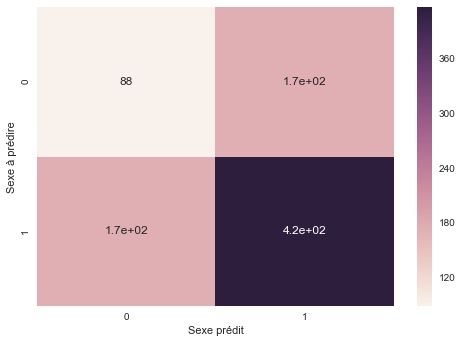

In [247]:
y_pred = clf.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")
## Bof, après différents test souvent pas top du tout...

### Régression logistique

In [144]:
#'criterion':('gini', 'entropy'), 
              #'n_estimators':[10,20,50],
parameters = {'penalty':("l1", "l2"),
             'C':[0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 8, 10, 20, 100]}

# On utilise comme score le score F1 pour une moyenne du rappel et de la précision (objectif sous-jacent) :
# ne pas coder trop souvnet en homme.
mod = LogisticRegression()
reg = GridSearchCV(mod, parameters, cv=5, scoring = "f1_weighted", verbose=5000)
reg.fit(feat_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=0.01, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ............... C=0.01, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s remaining:    0.0s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ............... C=0.05, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=0.05, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s remaining:    0.0s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ............... C=0.05, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.6s remaining:    0.0s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ............... C=0.05, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.7s remaining:    0.0s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ............... C=0.05, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s remaining:    0.0s
[CV] C=0.05, penalty=l2 ..............................................
[CV] ............... C=0.05, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ............... C=0.05, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.8s remaining:    0.0s
[CV] C=0.05, penalty=l2 ..............................................
[CV] ............... C=0.05, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.8s remaining:    0.0s
[CV] C=0.05, penalty=l2 ..............................................
[CV] ............... C=0.05, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.9s remaining:    0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[CV] C=0.1, penalty=l1 ...............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=0.1, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.1s remaining:    0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.1s remaining:    0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s remaining:    0.0s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s remaining:    0.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=0.1, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s remaining:    0.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.4s remaining:    0.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.4s remaining:    0.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s remaining:    0.0s
[CV] C=0.2, penalty=l1 ...............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=0.2, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    1.6s remaining:    0.0s
[CV] C=0.2, penalty=l1 ...............................................
[CV] ................ C=0.2, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.6s remaining:    0.0s
[CV] C=0.2, penalty=l1 ...............................................
[CV] ................ C=0.2, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    1.7s remaining:    0.0s
[CV] C=0.2, penalty=l1 ...............................................
[CV] ................ C=0.2, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    1.7s remaining:    0.0s
[CV] C=0.2, penalty=l1 ...............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ................ C=0.2, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.8s remaining:    0.0s
[CV] C=0.2, penalty=l2 ...............................................
[CV] ................ C=0.2, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.8s remaining:    0.0s
[CV] C=0.2, penalty=l2 ...............................................
[CV] ................ C=0.2, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    1.9s remaining:    0.0s
[CV] C=0.2, penalty=l2 ...............................................
[CV] ................ C=0.2, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    1.9s remaining:    0.0s
[CV] C=0.2, penalty=l2 ...............................................
[CV] ................ C=0.2, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ................ C=0.5, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    2.0s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ................ C=0.5, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    2.1s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ................ C=0.5, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    2.2s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ................ C=0.5, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.2s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ................ C=0.5, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    2.3s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV] ................ C=0.5, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    2.3s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV] ................ C=0.5, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.4s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV] ................ C=0.5, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    2.4s remaining:    0.0s
[CV] C=0.5, penalty=l2 ...............................................
[CV] ................ C=0.5, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ................ C=0.7, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    2.5s remaining:    0.0s
[CV] C=0.7, penalty=l1 ...............................................
[CV] ................ C=0.7, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    2.5s remaining:    0.0s
[CV] C=0.7, penalty=l1 ...............................................
[CV] ................ C=0.7, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    2.6s remaining:    0.0s
[CV] C=0.7, penalty=l1 ...............................................
[CV] ................ C=0.7, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.6s remaining:    0.0s
[CV] C=0.7, penalty=l1 ...............................................
[CV] ................ C=0.7, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

[CV] ................ C=0.7, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    2.7s remaining:    0.0s
[CV] C=0.7, penalty=l2 ...............................................
[CV] ................ C=0.7, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    2.8s remaining:    0.0s
[CV] C=0.7, penalty=l2 ...............................................
[CV] ................ C=0.7, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    2.9s remaining:    0.0s
[CV] C=0.7, penalty=l2 ...............................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=0.7, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.1s remaining:    0.0s
[CV] C=1, penalty=l1 .................................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .................. C=1, penalty=l1, score=0.559392, total=   0.1s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    3.3s remaining:    0.0s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    3.5s remaining:    0.0s
[CV] C=1, penalty=l1 .................................................


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .................. C=1, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    3.6s remaining:    0.0s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.6s remaining:    0.0s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.564717, total=   0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    3.7s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] .................. C=1, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    3.7s remaining:    0.0s
[CV] C=1, penalty=l2 .................................................
[CV] .................. C=1, penalty=l2, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=1.5, penalty=l1, score=0.559392, total=   0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    4.0s remaining:    0.0s
[CV] C=1.5, penalty=l1 ...............................................
[CV] ................ C=1.5, penalty=l1, score=0.569815, total=   0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    4.1s remaining:    0.0s
[CV] C=1.5, penalty=l1 ...............................................
[CV] ................ C=1.5, penalty=l1, score=0.557498, total=   0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    4.2s remaining:    0.0s
[CV] C=1.5, penalty=l1 ...............................................
[CV] ................ C=1.5, penalty=l1, score=0.568197, total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    4.3s remaining:    0.0s
[CV] C=1.5, penalty=l1 ...............................................
[CV] ................ C=1.5, penalty=l1, score=0.568197, total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=1.5, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    4.5s remaining:    0.0s
[CV] C=1.5, penalty=l2 ...............................................
[CV] ................ C=1.5, penalty=l2, score=0.561140, total=   0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.6s remaining:    0.0s
[CV] C=2, penalty=l1 .................................................
[CV] .................. C=2, penalty=l1, score=0.561989, total=   0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    4.7s remaining:    0.0s
[CV] C=2, penalty=l1 .................................................
[CV] .................. C=2, penalty=l1, score=0.584694, total=   0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    4.8s remaining:    0.0s
[CV] C=2, penalty=l1 .................................................
[CV] .................. C=2, penalty=l1, score=0.576171, total=   0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=2.5, penalty=l1, score=0.575247, total=   0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    5.3s remaining:    0.0s
[CV] C=2.5, penalty=l1 ...............................................
[CV] ................ C=2.5, penalty=l1, score=0.580932, total=   0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    5.3s remaining:    0.0s
[CV] C=2.5, penalty=l1 ...............................................
[CV] ................ C=2.5, penalty=l1, score=0.580665, total=   0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    5.4s remaining:    0.0s
[CV] C=2.5, penalty=l1 ...............................................
[CV] ................ C=2.5, penalty=l1, score=0.579039, total=   0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    5.5s remaining:    0.0s
[CV] C=2.5, penalty=l1 ...............................................
[CV] ................ C=2.5, penalty=l1, score=0.570686, total=   0.0s
[Parallel(n_jobs=1)]: Done  95 out of  95

[CV] .................. C=4, penalty=l2, score=0.573629, total=   0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    8.4s remaining:    0.0s
[CV] C=5, penalty=l1 .................................................
[CV] .................. C=5, penalty=l1, score=0.649461, total=   0.0s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    8.5s remaining:    0.0s
[CV] C=5, penalty=l1 .................................................
[CV] .................. C=5, penalty=l1, score=0.608692, total=   0.0s
[Parallel(n_jobs=1)]: Done 132 out of 132 | elapsed:    8.6s remaining:    0.0s
[CV] C=5, penalty=l1 .................................................
[CV] .................. C=5, penalty=l1, score=0.611899, total=   0.0s
[Parallel(n_jobs=1)]: Done 133 out of 133 | elapsed:    8.7s remaining:    0.0s
[CV] C=5, penalty=l1 .................................................
[CV] .................. C=5, penalty=l1, score=0.615787, total=   0.0s
[Parallel(n_jobs=1)]: Done 134 out of 134

[CV] ................ C=100, penalty=l1, score=0.658197, total=   0.6s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:  4.1min remaining:    0.0s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.605001, total=  48.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:  4.9min remaining:    0.0s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.633222, total=   1.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:  4.9min remaining:    0.0s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.633481, total=  45.3s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:  5.7min remaining:    0.0s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.610871, total=  48.1s
[Parallel(n_jobs=1)]: Done 175 out of 175

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': [0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 8, 10, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=5000)

In [146]:
# Prédiction globale
reg.score(X=feat_test, y=y_test)

0.6028980945271196

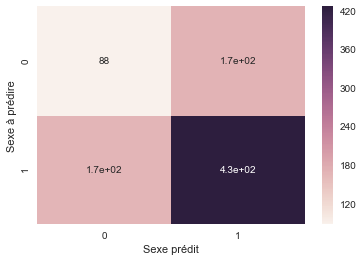

In [147]:
y_pred = reg.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Réseaux de neurones

In [256]:
# A faire

array([[  0, 260],
       [  0, 591]])

## Comparaison de diverses méthodes

In [142]:
import pandas
import time
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X = feat_train.toarray()
Y = y_train

# prepare models

t_debut = time.time()

models = []
models.append(("Classification aléatoire", DummyClassifier(strategy="stratified")))
models.append(('Régression logistique pénalité L1', LogisticRegression(penalty = "l1")))
models.append(('Régression logistique pénalité L2', LogisticRegression(penalty = "l2")))
models.append(('Forêts aléatoires', RandomForestClassifier()))
models.append(('Plus proches voisins', KNeighborsClassifier()))
models.append(('Réseaux de neurones', MLPClassifier()))
models.append(('Classificateur naïf bayésien', GaussianNB()))
models.append(('Machine à vecteur de support', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'#'f1_weighted'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
t_fin = time.time() 
temps_exec = t_fin - t_debut
msg_temps = "Temps d'exéccution en secondes de" % (temps_exec) 
print(msg_temps)


Classification aléatoire: 0.477242 (0.021611)


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

Régression logistique pénalité L1: 0.407050 (0.010653)


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

Régression logistique pénalité L2: 0.407240 (0.009520)
Forêts aléatoires: 0.475158 (0.023713)
Plus proches voisins: 0.542933 (0.024040)
Réseaux de neurones: 0.557581 (0.039563)
Classificateur naïf bayésien: 0.554577 (0.021935)


C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\metrics\c

Machine à vecteur de support: 0.407307 (0.006733)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

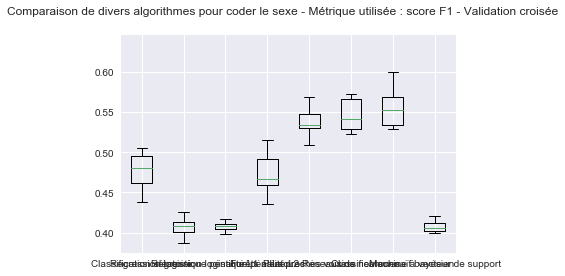

In [143]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparaison de divers algorithmes pour coder le sexe - Métrique utilisée : score F1 - Validation croisée')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
## Peut encore (beaucoup...) s'améliorer... A voir avec les matrices de confusion si le score F1 est une bonne métrique.

In [ ]:
## Pour poursuivre.
## Etudier les probabilités prédites, et comprendre ce qu'il se passe pour les bien codés avec forte confiance, 
## et mal codés avec forte confiance.
## Au Japon, langue plus différenciée entre hommes et femmes, donc devrait bien marcher ?

### ACP sur mots

In [150]:
from sklearn.decomposition import TruncatedSVD
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train)
feat_train_svd = pipe_svd.transform(X_train)
feat_train_svd.shape

(2553, 300)

In [151]:
clf_svd = RandomForestClassifier(n_estimators=50)
clf_svd.fit(feat_train_svd, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [153]:
feat_test_svd = pipe_svd.transform(X_test)
clf_svd.score(feat_test_svd, y_test)

0.700352526439483

In [2]:
y_pred = clf_svd.predict(feat_test_svd)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

NameError: name 'clf_svd' is not defined

In [160]:
# Avec scoring tf-idf en sus
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train)
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train)

clf_svd_tfidf = RandomForestClassifier(n_estimators=50)
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test)
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.6944770857814336

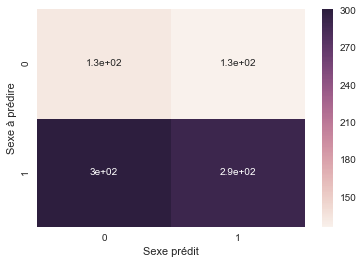

In [161]:
y_pred = clf_svd_tfidf.predict(feat_test_svd)

cnf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sn
import matplotlib.pyplot as plt

matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

### Approche Word2Vec

In [165]:
import os
import spacy
unzip_dest = 'en_core_web_md-2.0.0.tar/dist/en_core_web_md-2.0.0/en_core_web_md/en_core_web_md-2.0.0'
if not os.path.exists(unzip_dest):
    from pyquickhelper.pycode import is_travis_or_appveyor
    if not is_travis_or_appveyor():
        # On le fait seulement si ce n'est pas un test d'intégration continue.
        url = "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.0.0/"
        name = "en_core_web_md-2.0.0.tar.gz"
        print("Téléchargement de ", name)
        from pyensae.datasource import download_data
        unzipped = download_data(name, url=url, fLOG=print)
        unzip_dest = os.path.split(unzipped[0])[0]
        unzip_dest = "en_core_web_md-2.0.0/en_core_web_md/en_core_web_md-2.0.0"
        print("Found", unzip_dest)

if os.path.exists(unzip_dest):
    print("Chargement des données par spacy.")
    nlp = spacy.load(unzip_dest)
    continue_wv = True
else:
    continue_wv = False
    print('Pas de données on passe la suite.')

Téléchargement de  en_core_web_md-2.0.0.tar.gz
Found en_core_web_md-2.0.0/en_core_web_md/en_core_web_md-2.0.0
Chargement des données par spacy.


NameError: name 'spacy' is not defined

In [1]:
!pip install spacy


  Using cached https://files.pythonhosted.org/packages/15/af/c3f04f1bddf402e59342ad9d2407343d2eaf1a279e3af94879168b61f2b8/spacy-2.0.18-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/e4/a3/7a02574e8ed71d7a05660550af2b96ec03f96f2b98d76d5fe4133cf7571b/thinc-6.12.1-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/16/c4/79f3409bc710559015464e5f49b9879430d8f87498ecdc335899732e5377/ujson-1.35.tar.gz
  Using cached https://files.pythonhosted.org/packages/36/f4/9728ba01ccb2f55df9a5af029b48ba0aaca1081bbd7823ea2ee223ba7a42/cytoolz-0.9.0.1.tar.gz
  Running setup.py bdist_wheel for ujson: started
  Running setup.py bdist_wheel for ujson: finished with status 'error'
  Complete output from command c:\users\maxim\anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\maxim\\AppData\\Local\\Temp\\pip-install-ywu_rgfd\\ujson\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.c

  Failed building wheel for ujson
  Failed building wheel for cytoolz
Cannot uninstall 'cytoolz'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [170]:
### Modèles non pré-entraînés
import numpy

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train, model)
wv_train_feat.shape

AttributeError: 'SVC' object has no attribute 'wv'